# Observe other vision practices that have moved to large messaging in Spine

On the 23rd March 2021, three more Vision practices enabled large messaging for GP2GP. We want to look at our Spine data for these practices to identify how their failure rates have changed since moving to large messaging. 

### Scope

Analyse spine data for the following three practices, for transfers both in and out:

Went live with large messaging from: 23.03.21 - 12.16pm 

User ID | Practice Code | Practice Name

#668 | M89019 | Hobs Moat Medical Centre

#33018 | M82010 | Drayton Medical Centre

#857 | H84023 | Essex House Surgery

- Document the technical success rate of their transfers for three months prior to 23.03
- Document a high level breakdown of reasons for failures for this time period.
- Document the technical success rate of their transfers since 23.03. 
- Document a high level breakdown of reasons for this time period

 
### Acceptance Criteria
- We are able to compare the technical success rate for these two practices before and after enabling attachments, and communicate to stakeholders how much their failure rates have changed. 
- We are able to tell the Vision team the reasons for some transfers still failing since moving to Large messaging

In [139]:
from datetime import datetime,timedelta
import matplotlib.pyplot as plt

practice_codes=["M89019","M82010","H84023"]
time_of_switch=datetime(year=2021, month=3, day=23, hour=12, minute=16)
window=timedelta(28) # Number of Days before and after switch to consider changes

start_time=time_of_switch-window
end_time=time_of_switch+window

In [34]:
import pandas as pd
import numpy as np

transfer_file_location = "s3://prm-gp2gp-data-sandbox-dev/transfers-duplicates-hypothesis/"
transfer_files = [
    "9-2020-transfers.parquet",
    "10-2020-transfers.parquet",
    "11-2020-transfers.parquet",
    "12-2020-transfers.parquet",
    "1-2021-transfers.parquet",
    "2-2021-transfers.parquet",
    "3-2021-transfers.parquet",
    "4-2021-transfers.parquet",
]
transfer_input_files = [transfer_file_location + f for f in transfer_files]
transfers_raw = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))
# This is only needed when using transfers-duplicates-hypothesis datasets
transfers_raw = transfers_raw.drop(["sending_supplier", "requesting_supplier"], axis=1)

# Given the findings in PRMT-1742 - many duplicate EHR errors are misclassified, the below reclassifies the relevant data
successful_transfers_bool = transfers_raw['request_completed_ack_codes'].apply(lambda x: True in [(np.isnan(i) or i==15) for i in x])
transfers = transfers_raw.copy()
transfers.loc[successful_transfers_bool, "status"] = "INTEGRATED"

# Pending (Sender Error) Code
pending_sender_error_codes=[6,7,10,24,30,23,14,99]
transfers_with_pending_sender_code_bool=transfers['sender_error_code'].isin(pending_sender_error_codes)
transfers_with_pending_with_error_bool=transfers['status']=='PENDING_WITH_ERROR'
transfers_which_need_pending_to_failure_change_bool=transfers_with_pending_sender_code_bool & transfers_with_pending_with_error_bool
transfers.loc[transfers_which_need_pending_to_failure_change_bool,'status']='FAILED'

# Add integrated Late status
eight_days_in_seconds=8*24*60*60
transfers_after_sla_bool=transfers['sla_duration']>eight_days_in_seconds
transfers_with_integrated_bool=transfers['status']=='INTEGRATED'
transfers_integrated_late_bool=transfers_after_sla_bool & transfers_with_integrated_bool
transfers.loc[transfers_integrated_late_bool,'status']='INTEGRATED LATE'


# Supplier name mapping
supplier_renaming = {
    "EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)":"EMIS",
    "IN PRACTICE SYSTEMS LTD":"Vision",
    "MICROTEST LTD":"Microtest",
    "THE PHOENIX PARTNERSHIP":"TPP",
    None: "Unknown"
}

asid_lookup_file = "s3://prm-gp2gp-data-sandbox-dev/asid-lookup/asidLookup-Mar-2021.csv.gz"
asid_lookup = pd.read_csv(asid_lookup_file)
lookup = asid_lookup[["ASID", "MName", "NACS","OrgName"]]

transfers = transfers.merge(lookup, left_on='requesting_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'requesting_supplier', 'ASID': 'requesting_supplier_asid', 'NACS': 'requesting_ods_code',"OrgName":'requesting_practice'}, axis=1)
transfers = transfers.merge(lookup, left_on='sending_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'sending_supplier', 'ASID': 'sending_supplier_asid', 'NACS': 'sending_ods_code',"OrgName":'sending_practice'}, axis=1)

transfers["sending_supplier"] = transfers["sending_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())
transfers["requesting_supplier"] = transfers["requesting_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())

In [44]:
# list(row['sender_error_code'], , row['request_completed_ack_codes'])
transfers['all_errors']=transfers.apply(lambda row:np.concatenate((np.append(row["intermediate_error_codes"], row["sender_error_code"]),row['request_completed_ack_codes'])), axis=1)
transfers['all_errors']=transfers['all_errors'].apply(lambda error_list:[error for error in error_list if np.isfinite(error)])



In [61]:
transfers['unique_errors']=transfers['all_errors'].apply(set).apply(list)



In [102]:
error_code_lookup_file = pd.read_csv("https://raw.githubusercontent.com/nhsconnect/prm-gp2gp-data-sandbox/master/data/gp2gp_response_codes.csv")

### Extract the data relevant to the practices in question

In [62]:
requesting_transfers_bool=transfers["requesting_ods_code"].isin(practice_codes)
requesting_transfers=transfers.loc[requesting_transfers_bool].copy()
requesting_transfers['ods_code']=requesting_transfers['requesting_ods_code']
requesting_transfers['transfer type']='Requesting'
requesting_transfers['practice']=requesting_transfers['requesting_practice']

sending_transfers_bool=transfers["sending_ods_code"].isin(practice_codes)
sending_transfers=transfers.loc[sending_transfers_bool].copy()
sending_transfers['ods_code']=sending_transfers['sending_ods_code']
sending_transfers['transfer type']='Sending'
sending_transfers['practice']=sending_transfers['sending_practice']

relevant_transfers=pd.concat([requesting_transfers,sending_transfers],axis=0)

In [83]:
relevant_transfers['Large Messaging Available']=relevant_transfers['date_requested']>time_of_switch
relevant_transfers_in_time_window_bool=(relevant_transfers['date_requested']>=start_time) & (relevant_transfers['date_requested']<=end_time)
relevant_transfers=relevant_transfers.loc[relevant_transfers_in_time_window_bool]
relevant_transfers['Large Messaging Available']=relevant_transfers['Large Messaging Available'].astype(str)

In [177]:
lm_error_codes=[14,23,29,30,31]
relevant_transfers['Contains LM related error']=relevant_transfers['all_errors'].apply(lambda error_list: len(set(error_list).intersection(set(lm_error_codes)))>0)

## What is the change in outcomes (status) as a result?

In [93]:
def outcomes_pc_table(transfers_df,pivot_index):
    outcomes_table=pd.pivot_table(transfers_df,index=pivot_index,columns='status',values='conversation_id',aggfunc='count').fillna(0)
    return (100*outcomes_table.div(outcomes_table.sum(axis=1),axis=0)).round(2)

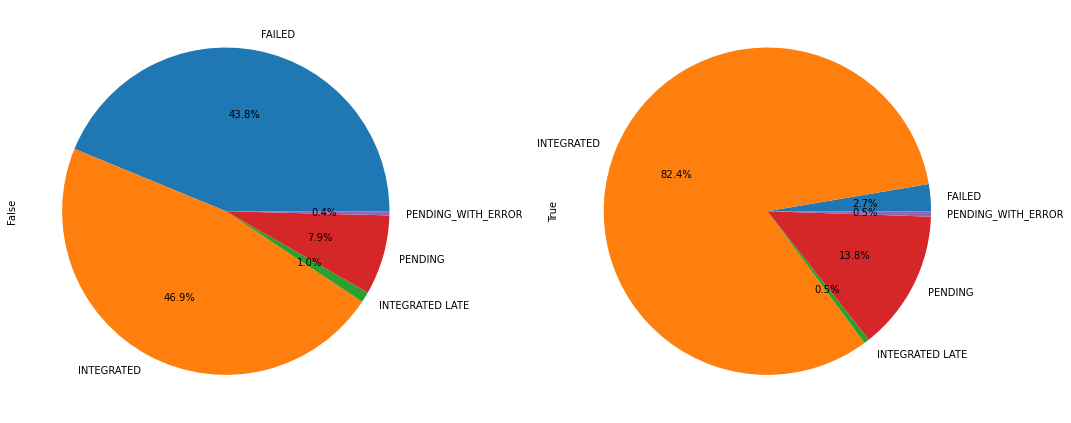

In [142]:
high_level_table=outcomes_pc_table(relevant_transfers,['Large Messaging Available'])
high_level_table.T.plot.pie(subplots=True,figsize=(15,10),legend=False,autopct='%1.1f%%')
plt.tight_layout()

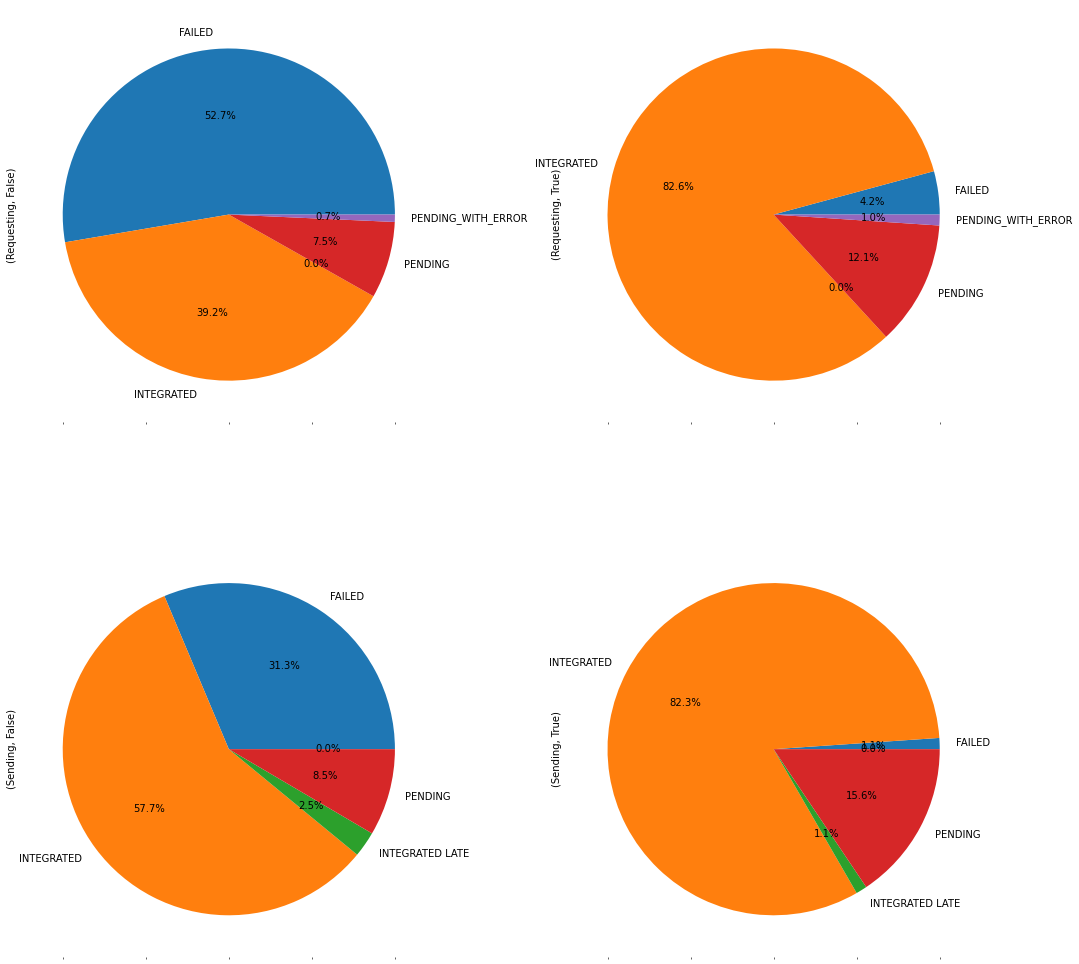

In [151]:
mid_level_table=outcomes_pc_table(relevant_transfers,['transfer type','Large Messaging Available'])
mid_level_table.T.plot.pie(subplots=True,layout=(2,2),figsize=(15,15),legend=False,autopct='%1.1f%%')
plt.tight_layout()

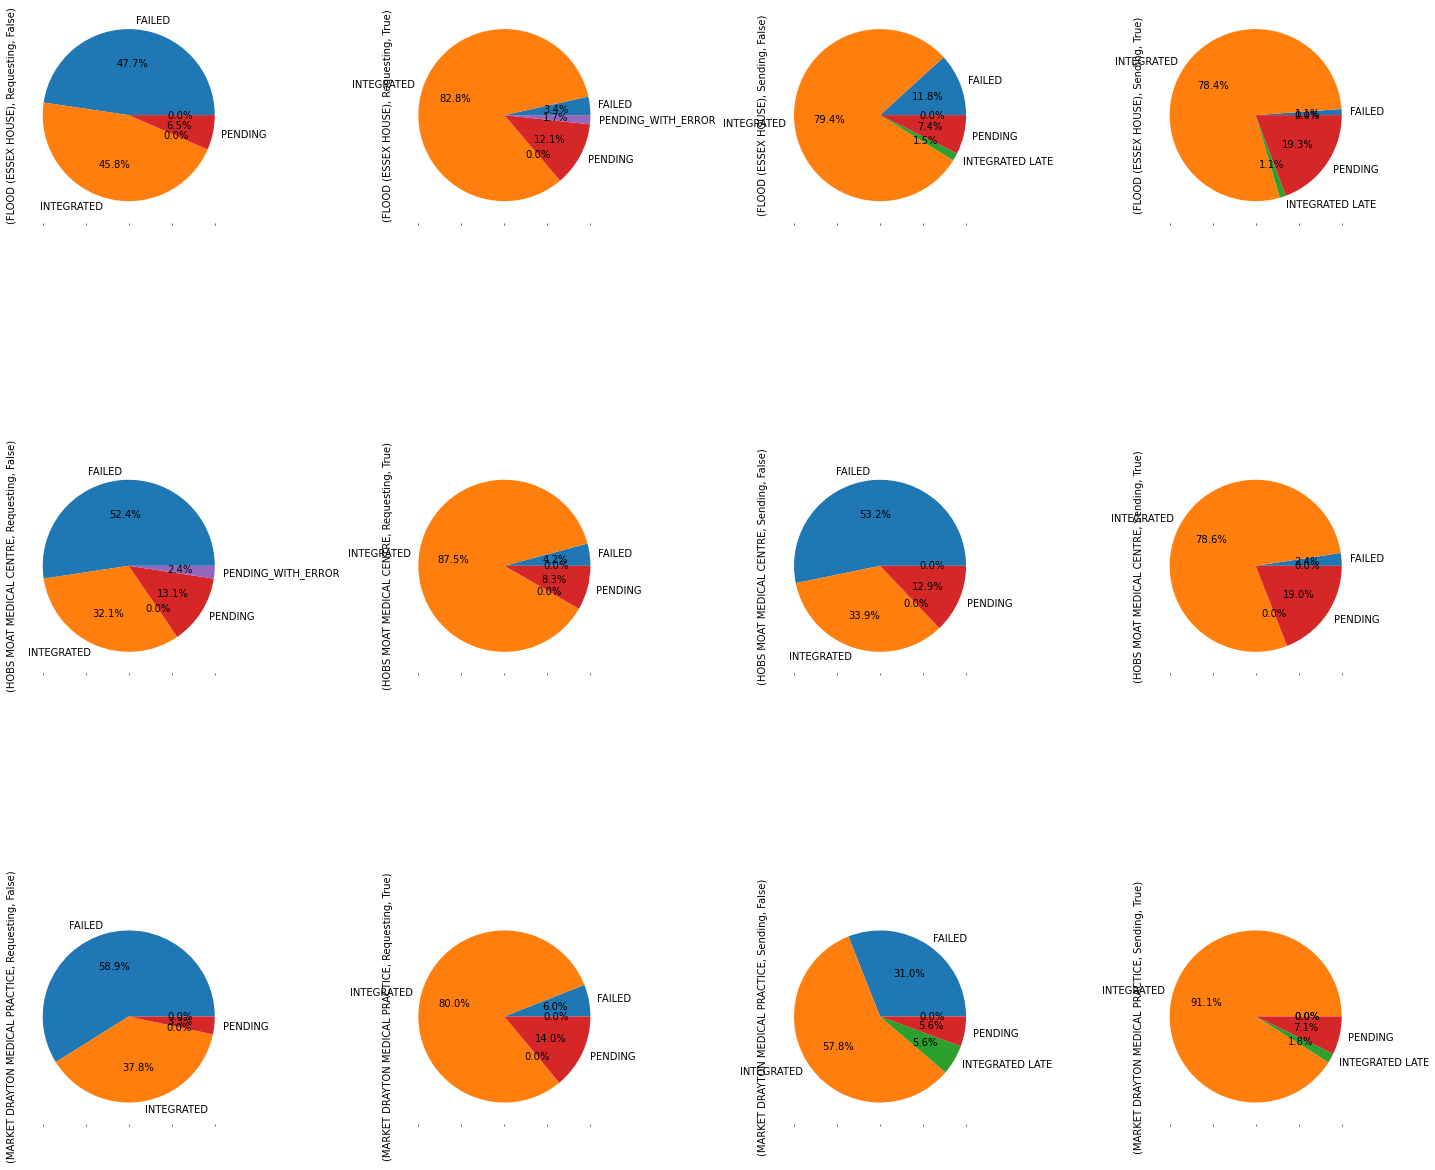

In [179]:
granular_table=outcomes_pc_table(relevant_transfers,["practice",'transfer type','Large Messaging Available'])
granular_table.T.plot.pie(subplots=True,layout=(3, 4),figsize=(20,20),legend=False,autopct='%1.1f%%')
plt.tight_layout()

### What is the change in errors

In [123]:
def outcomes_pc_table_exploding_input(transfers_df,exploding_column,pivot_index):
    lm_error_changes=pd.pivot_table(transfers_df.explode(exploding_column),index=pivot_index,columns=exploding_column,values='conversation_id', aggfunc='count').fillna(0)
    transfer_counts=transfers_df[pivot_index].value_counts()[lm_error_changes.index]
    return (lm_error_changes.div(transfer_counts, axis=0)*100).round(2)

def rename_errors_table(error_table,error_name_dict):
    error_table.columns=[error_name_dict[column] for column in error_table.columns]
    return error_table.T

error_names_dict=error_code_lookup_file.set_index('ErrorCode').to_dict()['ErrorName']

<AxesSubplot:>

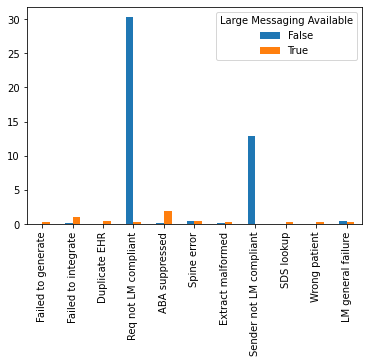

In [161]:
error_code_high_level=outcomes_pc_table_exploding_input(relevant_transfers,'unique_errors','Large Messaging Available')
error_code_high_level=rename_errors_table(error_code_high_level,error_names_dict)
error_code_high_level.plot.bar()

array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

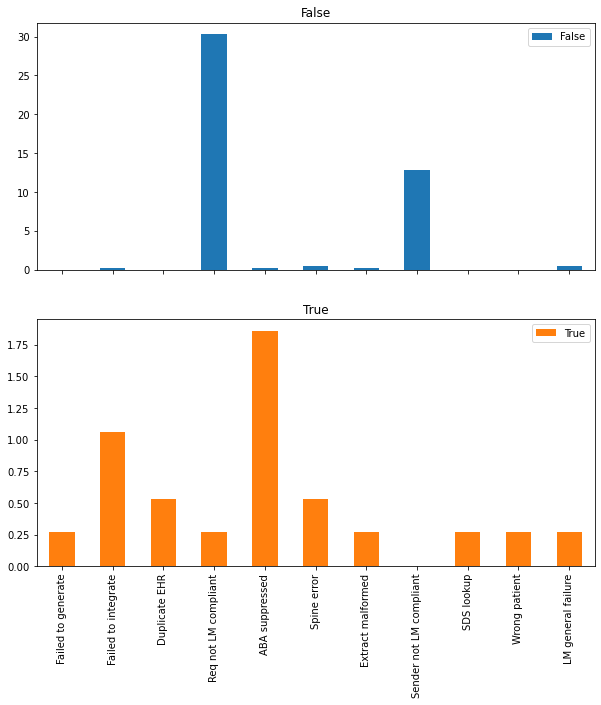

In [172]:
error_code_high_level.plot.bar(subplots=True,figsize=(10,10))

status                    FAILED       INTEGRATED INTEGRATED LATE PENDING  \
Contains LM related error  False True       False           False   False   
Large Messaging Available                                                   
False                          1   210        226               5      38   
True                           8     2        310               2      52   

status                    PENDING_WITH_ERROR  
Contains LM related error              False  
Large Messaging Available                     
False                                      2  
True                                       2

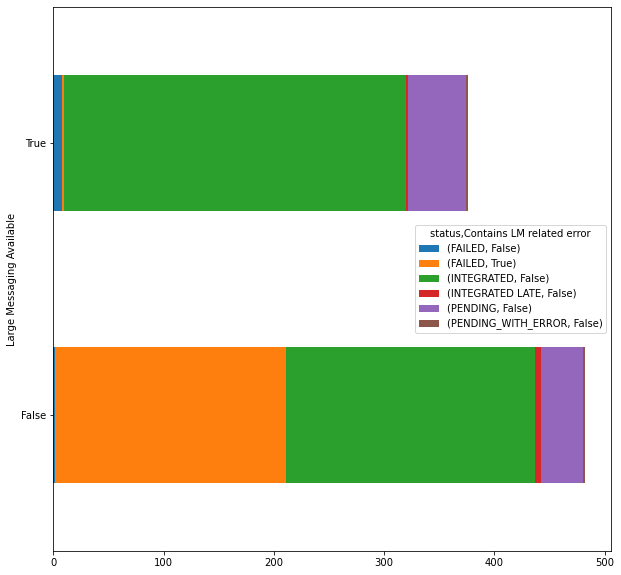

In [208]:
lm_error_status_table=pd.pivot_table(relevant_transfers,index=['Large Messaging Available'],columns=['status','Contains LM related error'],values='conversation_id',aggfunc='count')
lm_error_status_table.plot.barh(stacked=True,figsize=(10,10))
lm_error_status_table

<AxesSubplot:ylabel='Large Messaging Available'>

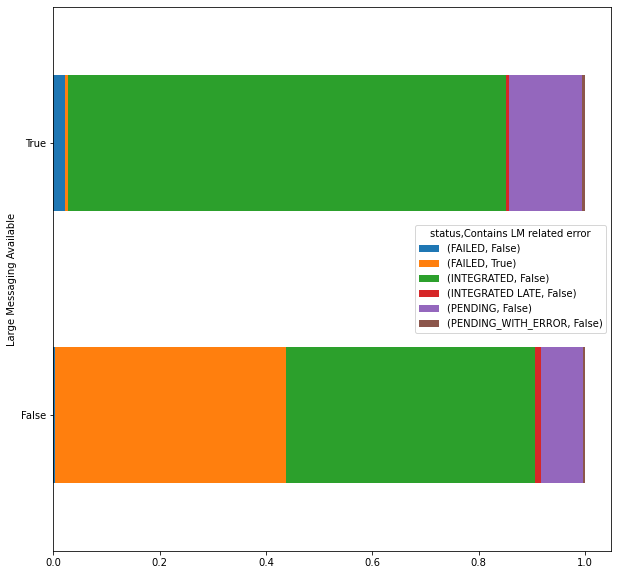

In [207]:
lm_error_status_table.div(lm_error_status_table.sum(axis=1),axis=0).plot.barh(stacked=True,figsize=(10,10))

In [195]:
area_of_interest_bool=(relevant_transfers['status']=='FAILED') & (relevant_transfers['Large Messaging Available']=='True')
errors_of_interest=relevant_transfers.loc[area_of_interest_bool,'unique_errors'].explode().value_counts()
errors_of_interest.index=[error_names_dict[index] for index in errors_of_interest.index]
errors_of_interest

Failed to integrate     4
Req not LM compliant    1
LM general failure      1
Duplicate EHR           1
Failed to generate      1
SDS lookup              1
Extract malformed       1
Wrong patient           1
Name: unique_errors, dtype: int64

In [ ]:
relevant_transfers['LM status']=relevant_transfers['status']